# 🍔👁 Food Vision Big™

We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

All 75,750 training images and 25,250 testing images.

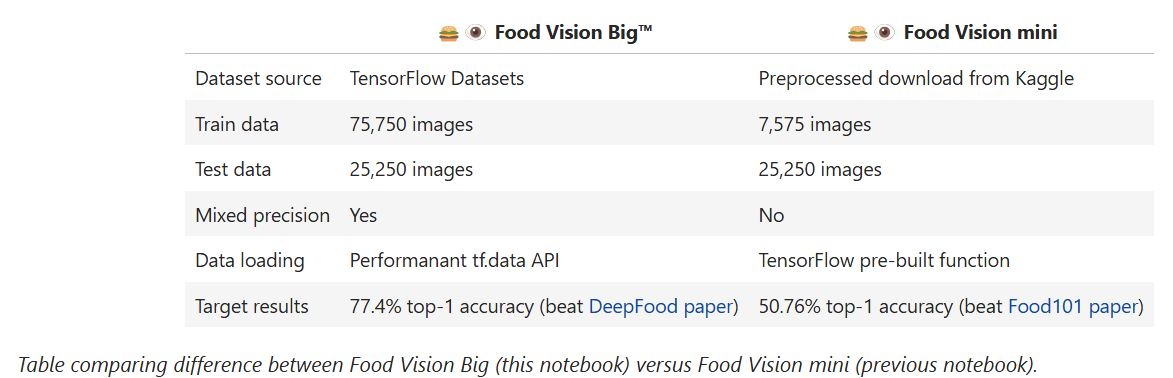

Alongside attempting to beat the DeepFood paper, we're going to learn about two methods to significantly improve the speed of our model training:

1. Prefetching
2. Mixed precision training

But more on these later.

### What we're going to cover
* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (making our datasets run fast)
* Creating modelling callbacks
* Setting up mixed precision training
* Building a feature extraction model (see transfer learning part 1: feature extraction)
* Fine-tuning the feature extraction model (see transfer learning part 2: fine-tuning)
* Viewing training results on TensorBoard

### Check GPU
For this notebook, we're going to be doing something different.

We're going to be using mixed precision training.

Mixed precision training uses a combination of single precision (float32) and half-preicison (float16) data types to speed up model training (up 3x on modern GPUs).

For mixed precision training to work, you need access to a GPU with a compute compability score of 7.0+.

In [ ]:
# Get GPU name
!nvidia-smi -L

In [ ]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

import datetime
from datetime import timezone
from zoneinfo import ZoneInfo
print(f"Notebook last run: {datetime.datetime.now(tz=ZoneInfo('Europe/Istanbul'))}")

In [ ]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
  print("[INFO] 'helper_functions.py' already exists, skipping download...")

In [ ]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

In previous notebooks, we've downloaded our food images (from the Food101 dataset) from Google Storage.

And this is a typical workflow you'd use if you're working on your own datasets.

However, there's another way to get datasets ready to use with TensorFlow.

For many of the most popular datasets in the machine learning world (often referred to and used as benchmarks), you can access them through **TensorFlow Datasets (TFDS)**.

What is **TensorFlow Datasets?**

A place for prepared and ready-to-use machine learning datasets.

Why use TensorFlow Datasets?

* Load data already in Tensors
* Practice on well established datasets
* Experiment with differet data loading techniques (like we're going to use in this notebook)
* Experiment with new TensorFlow features quickly (such as mixed precision training)

Why not use TensorFlow Datasets?

* The datasets are static (they don't change, like your real-world datasets would)
* Might not be suited for your particular problem (but great for experimenting)

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# Get all available datasets in TFDS
datasets_list = tfds.list_builders()

# Set our target dataset and see if it exist
target_dataset = 'food101'
print(f"{target_dataset} in TensorFlow Datasets: {target_dataset in datasets_list}")

In [ ]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [ ]:
len(train_data), len(test_data)

In [ ]:
train_data, test_data

In [ ]:
# Feature  of Food101 TFDS
ds_info.features

In [ ]:
# Get class names
class_names = ds_info.features['label'].names
class_names[:10]

### Exploring the Food101 data from TensorFlow Datasets

Let's find out a few details about our dataset:

* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

In [ ]:
# Take on sample off the training data
train_one_sample = train_data.take(1)
train_one_sample

Let's loop through our single training sample and get some info from the `image_tensor` and `label`.

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)

In [ ]:
image

### Plot an image from TensorFlow Datasets

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label])
plt.axis(False);

## Create preprocessing functions for our data

In previous notebooks, when our images were in folder format we used the method `tf.keras.utils.image_dataset_from_directory()` to load them in.

Doing this meant our data was loaded into a format ready to be used with our models.

However, since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model.

More specifically, our data is currently:

* In `uint8` data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In `float32` data type
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. `(224, 224, 3)`)
* Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using `tf.image.resize()`
* Converts an input image tensor's current datatype to `tf.float32` using `tf.cast()`

In [ ]:
# Make a function for preprocessing images
def preprocessing_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' to 'float32' and reshape image to
  [img_shape, img_shape, color_channels]
  """

  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocessing_img(image,label)[0]
print(f"Image before preprocessing:\n{image[:2]}...\nShape: {image.shape}\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...\nShape: {preprocessed_img.shape}\nDatatype: {preprocessed_img.dtype}")

In [ ]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255)
plt.title(class_names[label])
plt.axis(False);

## Batch and prepare datasets

Specifically, we're going to be using:

* `map()` - maps a predefined function to a target dataset (e.g. `preprocess_img()` to our image tensors)
* `shuffle()` - randomly shuffles the elements of a target dataset up `buffer_size` (ideally, the `buffer_size` is equal to the size of the dataset, however, this may have implications on memory)
* `batch()` - turns elements of a target dataset into batches (size defined by parameter `batch_size`)
* `prefetch()` - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
* Extra: `cache()` - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)

Things to note:

* Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our `preprocess_img()` function)
* `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
* For methods with the `num_parallel_calls` parameter available (such as `map()`), setting it to `num_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed
* Can't use `cache()` unless your dataset can fit in memory
Woah, the above is alot. But once we've coded below, it'll start to make sense.

We're going to through things in the following order:

`Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset`

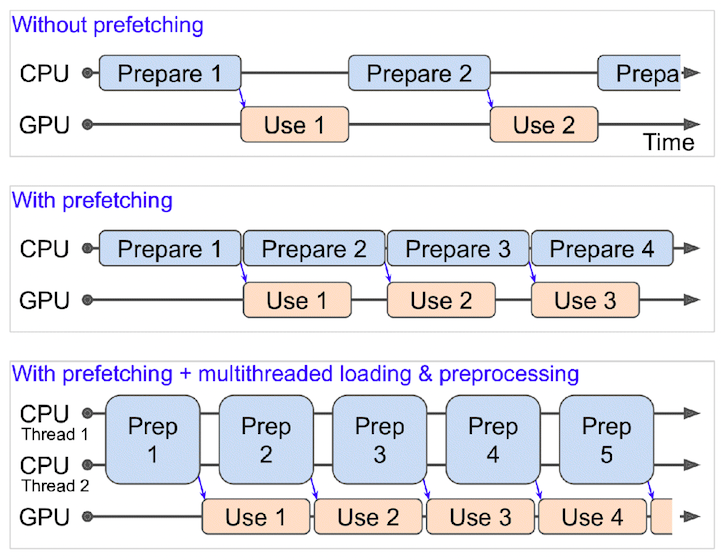

In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data_process = train_data.map(preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data_process and turn it into batches and prefetch it (load it faster)
train_data_process = train_data_process.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data_process = test_data.map(preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test_data_process into batches (don't need to shuffle)
test_data_process = test_data_process.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data_process, test_data_process

> 🔑 Note: You can get away without calling the prefetch() method on the end of your datasets, however, you'd probably see significantly slower data loading speeds when building a model. So most of your dataset input pipelines should end with a call to prefecth().

## Create modelling callbacks

We'll use the following callbacks:

* `tf.keras.callbacks.TensorBoard()` - allows us to keep track of our model's training history so we can inspect it later (note: we've created this callback before have imported it from `helper_functions.py` as `create_tensorboard_callback()`)
* `tf.keras.callbacks.ModelCheckpoint()` - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
  * Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [ ]:
# Create TensorBoard callback
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = 'model_checkpoins/cp.weights.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision training

Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).

In computer science, float32 is also known as `single-precision floating-point` format. The 32 means it usually occupies 32 bits in computer memory.

Your GPU has a limited memory, therefore it can only handle a number of float32 tensors at the same time.

This is where mixed precision training comes in.

Mixed precision training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory.

As mentioned before, when using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.

The beautiful thing is, the `tensorflow.keras.mixed_precision` API has made it very easy for us to get started.

First, we'll import the API and then use the `set_global_policy()` method to set the dtype policy to `"mixed_float16"`.

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

As long as the GPU you're using has a compute capability of 7.0+ the cell above should run without error.

Now we can check the global dtype policy (the policy which will be used by layers in our model) using the `mixed_precision.global_policy()` method.

In [ ]:
mixed_precision.global_policy()

## Build feature extraction model

Callbacks: ready to roll.

Mixed precision: turned on.

Let's build a model.

Because our dataset is quite large, we're going to move towards fine-tuning an existing pretrained model (EfficienetNetB0).

But before we get into fine-tuning, let's set up a feature-extraction model.

Recall, the typical order for using transfer learning is:

1. Build a feature extraction model (replace the top few layers of a pretrained model)
2. Train for a few epochs with lower layers frozen
3. Fine-tune if necessary with multiple layers unfrozen

To build the feature extraction model (covered in Transfer Learning in TensorFlow Part 1: Feature extraction), we'll:

* Use `EfficientNetB0` from `tf.keras.applications` pre-trained on ImageNet as our base model
  * We'll download this without the top layers using `include_top=False` parameter so we can create our own output layers
* Freeze the base model layers so we can use the pre-learned patterns the base model has found on ImageNet
* Put together the input, base model, pooling and output layers in a Functional model
* Compile the Functional model using the Adam optimizer and sparse categorical crossentropy as the loss function (since our labels **aren't** one-hot encoded)
* Fit the model for 3 epochs using the TensorBoard and ModelCheckpoint callbacks

> 🔑 **Note:** Since we're using mixed precision training, our model needs a separate output layer with a hard-coded `dtype=float32`, for example, `layers.Activation("softmax", dtype=tf.float32)`. This ensures the outputs of our model are returned back to the float32 data type which is more numerically stable than the float16 datatype (important for loss calculations). See the "Building the model" section in the TensorFlow mixed precision guide for more.

In [ ]:
from tensorflow.keras import layers

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

input_shape = (224,224,3)
inputs = layers.Input(input_shape, name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
x = layers.Dense(len(class_names), name='dense_layer')(x)
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation('softmax', dtype=tf.float32, name='activation_layer')(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
# Check out our model
model.summary()

### Checking layer dtype policy (are we using mixed precision?)

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

In [ ]:
# Check the layers in the base model and see what type policy they're using
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

## Fit the feature extraction model

In [ ]:
# Turn off all warnigns except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data_process.repeat(3),
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data_process),
                                                     validation_data=test_data_process,
                                                     validation_steps=int(0.15 * len(test_data_process)),
                                                     callbacks=[create_tensorboard_callback('training_logs',
                                                                                            'efficientnetb0_101_classes_all_data_feature_extrac'),
                                                                model_checkpoint])

In [ ]:
len(train_data_process)

In [ ]:
# Evaluate model
results_feature_extract_model = model.evaluate(test_data_process)
results_feature_extract_model

## TODO: Save the whole model to file

In [ ]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
!mkdir 'ManuallySave'
# Save just weights
model.save_weights('ManuallySave/man_model_weights..weights.h5')
# Save entire model
model.save('ManuallySave/man_all_model.keras')

In [ ]:
# Load model previously saved above
loaded_model = tf.keras.models.load_model('ManuallySave/man_all_model.keras')
loaded_model.summary()

In [ ]:
loaded_model.evaluate(test_data_process)

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for item in base_model.layers[20]:
  print(item.dtype_policy)

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_feature_extract_loaded_model = loaded_model.evaluate(test_data_process)
results_feature_extract_loaded_model

In [ ]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables
import numpy as np
np.isclose(results_feature_extract_model, results_feature_extract_loaded_model)